In [1]:
# from numba import cuda

# cuda.select_device(0)
# cuda.close()

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np

2024-05-10 23:47:36.190570: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 23:47:36.190628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 23:47:36.190637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 23:47:36.197376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.preprocessing import image

Height of the object image: 56
Width of the object image:  44


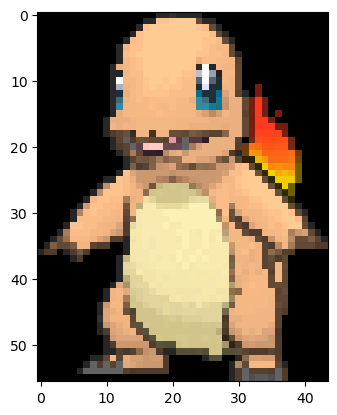

In [10]:
ch = image.load_img('/home/notomo/Documents/VSC/Models/ObjectLocalization/charmander-tight.png')
ch = ch.convert("RGB")
POKE_DIM = 200
ch = np.array(ch)
plt.imshow(ch)
CH_H, CH_W, CH_C = ch.shape

print(f'Height of the object image: {CH_H}')
print(f'Width of the object image:  {CH_W}')

In [4]:
def make_model():
    vgg = VGG16(input_shape= [POKE_DIM, POKE_DIM, 3], 
                include_top=False, 
                weights='imagenet')

    x = Flatten()(vgg.output)
    x = Dense(units=4, activation='sigmoid')(x) # 4 neurons corresponding to: x_topleft, y_topleft, height, width
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
    
    return model

In [5]:
def pokemon_generator(batch_size=8):
    while True:
        for _ in range(25): # number of batches in each epoch is just random (I chose 50)
            # Generate X - (batch_size, H, W, 3)
            # Generate y  - (batch_size, 4)
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            y = np.zeros(shape=(batch_size, 4)) # x_top_right, y_top_right, height, width

            for i in range(batch_size):
                x0 = np.random.randint(0, POKE_DIM - CH_W)
                y0 = np.random.randint(0, POKE_DIM - CH_H)
                x1 = x0 + CH_W
                y1 = y0 + CH_H

                X[i, y0:y1, x0:x1, :] = ch
                y[i, 0] = x0 / POKE_DIM
                y[i, 1] = y0 / POKE_DIM
                y[i, 2] = (y1-y0) / POKE_DIM
                y[i, 3] = (x1-x0) / POKE_DIM

            yield X / 255., y

In [6]:
model = make_model()

2024-05-10 23:47:42.879255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 23:47:42.962473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 23:47:42.962825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
model.fit_generator(
    pokemon_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


/tmp/ipykernel_10344/1671005762.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
2024-05-10 23:47:45.252600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-10 23:47:45.350646: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-10 23:47:45.516706: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 719.69MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-10 23:47:45.710276: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 719.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mea

50/50 [==============================] - 24s 308ms/step - loss: 0.6508
Epoch 2/5
50/50 [==============================] - 17s 337ms/step - loss: 0.5628
Epoch 3/5
50/50 [==============================] - 15s 304ms/step - loss: 0.5568
Epoch 4/5
50/50 [==============================] - 17s 345ms/step - loss: 0.5558
Epoch 5/5
50/50 [==============================] - 18s 371ms/step - loss: 0.5517


1/1 [==============================] - 0s 16ms/step


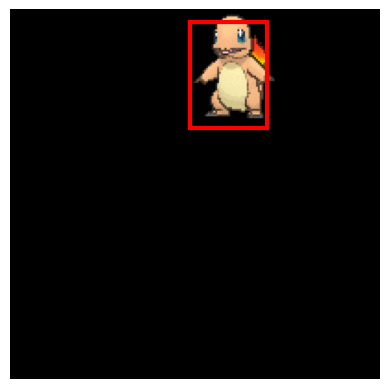

In [53]:
from matplotlib.patches import Rectangle

# Function to make prediction, everytime want to test the model, just run this function
def pokemon_predict():
    X = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    y = np.zeros(shape=(4)) # x_top_right, y_top_right, height, width
    x0 = np.random.randint(0, POKE_DIM - CH_W)
    y0 = np.random.randint(0, POKE_DIM - CH_H)
    x1 = x0 + CH_W
    y1 = y0 + CH_H

    X[y0:y1, x0:x1, :] = ch[:,:,:3]
    y[0] = x0 / POKE_DIM
    y[1] = y0 / POKE_DIM
    y[2] = (y1 - y0) / POKE_DIM
    y[3] = (x1 - x0) / POKE_DIM

    X = np.expand_dims(X, axis=0) / 255.
    y = np.expand_dims(y, axis=0)
    prediction = model.predict(X)[0]
    prediction = prediction * POKE_DIM
    rect = Rectangle((prediction[0], prediction[1]), 
                     height=prediction[2], width=prediction[3], 
                     edgecolor='r',
                     linewidth=3,
                     facecolor='none')
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X[0])
    ax.add_patch(rect)

    plt.show()


# Run function
pokemon_predict()